In [1]:
import MDAnalysis as mda
import numpy as np
import matplotlib as mpl
import MDAnalysis.analysis.rms as rms
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import numpy
from itertools import izip
import os

%matplotlib inline

# Order-Parameter Comparison Plot

In [63]:
def regularized_function(x, y, func, bins=100, range=None):
    """Compute *func()* over data aggregated in bins.
    ``(x,y) --> (x', func(Y'))``  with ``Y' = {y: y(x) where x in x' bin}``
    First the data is collected in bins x' along x and then *func* is
    applied to all data points Y' that have been collected in the bin.
    .. function:: func(y) -> float
       *func* takes exactly one argument, a numpy 1D array *y* (the
       values in a single bin of the histogram), and reduces it to one
       scalar float.
    .. Note:: *x* and *y* must be 1D arrays.
    :Arguments:
       x
          abscissa values (for binning)
       y
          ordinate values (func is applied)
       func
          a numpy ufunc that takes one argument, func(Y')
       bins
          number or array
       range
          limits (used with number of bins)
    :Returns:
       F,edges
          function and edges (``midpoints = 0.5*(edges[:-1]+edges[1:])``)
    (This function originated as
    :func:`recsql.sqlfunctions.regularized_function`.)
    """
    _x = numpy.asarray(x)
    _y = numpy.asarray(y)

    if len(_x.shape) != 1 or len(_y.shape) != 1:
        raise TypeError("Can only deal with 1D arrays.")

    # setup of bins (taken from numpy.histogram)
    if (range is not None):
        mn, mx = range
        if (mn > mx):
            raise AttributeError('max must be larger than min in range parameter.')

    if not numpy.iterable(bins):
        if range is None:
            range = (_x.min(), _x.max())
        mn, mx = [float(mi) for mi in range]
        if mn == mx:
            mn -= 0.5
            mx += 0.5
        bins = numpy.linspace(mn, mx, bins+1, endpoint=True)
    else:
        bins = numpy.asarray(bins)
        if (numpy.diff(bins) < 0).any():
            raise ValueError('bins must increase monotonically.')

    sorting_index = numpy.argsort(_x)
    sx = _x[sorting_index]
    sy = _y[sorting_index]

    # boundaries in SORTED data that demarcate bins; position in bin_index is the bin number
    bin_index = numpy.r_[sx.searchsorted(bins[:-1], 'left'),
                         sx.searchsorted(bins[-1], 'right')]

    # naive implementation: apply operator to each chunk = sy[start:stop] separately
    #
    # It's not clear to me how one could effectively block this procedure (cf
    # block = 65536 in numpy.histogram) because there does not seem to be a
    # general way to combine the chunks for different blocks, just think of
    # func=median
    F = numpy.zeros(len(bins)-1)  # final function
    F[:] = [func(sy[start:stop]) for start,stop in izip(bin_index[:-1],bin_index[1:])]
    return F,bins


def gates_DIM_proc(traj, top = "2jln_r10_g470_c22.psf"):
    u = mda.Universe(top, traj)
    traj_len = len(u.trajectory)

    gate1 = []
    gate2 = []
    gate3 = []

    for ts in u.trajectory:
        b_ec = u.select_atoms("resid 38:40") #select bundle for ec_thin comparison
        ec_thin = u.select_atoms("resid 351:353") #select extracellular thin gate
        b_ic = u.select_atoms("resid 152:154") #sic
        ic_thin = u.select_atoms("resid 220:222") #select intracellular thin gate
        b_tg = u.select_atoms("resid 29 or resid 32") #sic
        thick = u.select_atoms("resid 300 or resid 303:304") #select thick gate

        gate1_a = abs(b_ec.center_of_mass() - ec_thin.center_of_mass())
        gate2_a = abs(b_ic.center_of_mass() - ic_thin.center_of_mass())
        gate3_a = abs(b_tg.center_of_mass() - thick.center_of_mass())
        gate1_b = np.linalg.norm(gate1_a)
        gate2_b = np.linalg.norm(gate2_a)
        gate3_b = np.linalg.norm(gate3_a)

        gate1.append(gate1_b) #Ec_thin
        gate2.append(gate2_b) #Ic_thin
        gate3.append(gate3_b) #Thick Gate
    
    return gate1, gate2, gate3, traj_len

    

def delta_proc(init, targ, traj, top = "2jln_r10_g470_c22.psf", direction = "i2occ2o"):
    initial = mda.Universe(top, init)
    target = mda.Universe(top, targ)
    trajectory = mda.Universe(top, traj)

    r_init =  rms.RMSD(trajectory, initial, select='all')
    r_init.run()
    r_init.save("r_init")
    r_targ =  rms.RMSD(trajectory, target, select='all')
    r_targ.run()
    r_targ.save("r_targ")

    rmsd_init = r_init.rmsd.T
    rmsd_targ = r_targ.rmsd.T
    del_rmsd = rmsd_init[2] - rmsd_targ[2]
    time = rmsd_init[1]
    
    return del_rmsd, time

## Inward to Occluded to Outward

In [110]:
OB_trjs = [glob.glob("../data/dims/oliver/implicit_no_memb/in2occ2out/" 
                         + i + str(j).zfill(3) + "/*.dcd") 
               for i in ["gates/"] for j in xrange(20, 50)] # "gates/"

TC_trjs = [glob.glob("../data/dims/TC_DIMS_raw/in2occ2out/traj_" + str(i).zfill(3) + "/full*.dcd") for i in xrange(1, 11)]

ENMs = ["iENM/", "MAP/", "PATH-ENM/Steep_Descent/"]

legs = ["in2occ/", "out2occ/"]

ENM_trjs = [glob.glob("../data/public_servers/" + method + leg + "true*2.pdb")
                for leg in legs for method in ENMs]

In [70]:
len(TC_trjs), len(OB_trjs)

(10, 10)

In [69]:
TC_cat = mda.Universe("2jln_r10_g470_c22.psf", TC_trjs)
ag1 = TC_cat.select_atoms("protein")
with mda.Writer("TC_bag.dcd", ag1.n_atoms) as W:
    for ts in TC_cat.trajectory:
        W.write(ag1)


In [111]:
OB_cat = mda.Universe("2jln_r10_g470_c22.psf", OB_trjs)
ag2 = OB_cat.select_atoms("protein")
with mda.Writer("OB_bag.dcd", ag2.n_atoms) as W:
    for ts in OB_cat.trajectory:
        W.write(ag2)

In [76]:
u = mda.Universe("2jln_r10_g470_c22.psf", "OB_bag.dcd")
u.trajectory.n_frames

3612

Pre-processing of each trajectory type:

## Generate plot data for DIMS

In [71]:
initial = "../simulations/dims/implicit_solvent/implicit_membrane/emin/mhp1_i_mini.pdb" 
target = "../simulations/dims/implicit_solvent/implicit_membrane/emin/mhp1_o_mini.pdb"

#TC DIMs
TC_gate1, TC_gate2, TC_gate3, traj_len = gates_DIM_proc("TC_bag.dcd")
TC_del_rmsd, time = delta_proc(initial, target, "TC_bag.dcd")

TC_g_std_1, q1 = regularized_function(TC_del_rmsd, TC_gate1, np.std, bins=200)
TC_g_std_2, q1 = regularized_function(TC_del_rmsd, TC_gate2, np.std, bins=200)
TC_g_std_3, q1 = regularized_function(TC_del_rmsd, TC_gate3, np.std, bins=200)

TC_g_mean_1, q1 = regularized_function(TC_del_rmsd, TC_gate1, np.mean, bins=200)
TC_g_mean_2, q1 = regularized_function(TC_del_rmsd, TC_gate2, np.mean, bins=200)
TC_g_mean_3, q1 = regularized_function(TC_del_rmsd, TC_gate3, np.mean, bins=200)

TC_zeta = 0.5*(q1[1:] + q1[:-1])


RMSD  3.41 A at frame  2313/2313  [100.0%]
RMSD  1.57 A at frame  2313/2313  [100.0%]
RMSD  3.74 A at frame  6804/6804  [100.0%]
RMSD  2.42 A at frame  6804/6804  [100.0%]


In [112]:
#OB_DIMs

OB_gate1, OB_gate2, OB_gate3, traj_len = gates_DIM_proc("OB_bag.dcd")
OB_del_rmsd, time = delta_proc("i_opn.pdb", "o_opn.pdb", "OB_bag.dcd")

OB_g_std_1, q2 = regularized_function(OB_del_rmsd, OB_gate1, np.std, bins=200)
OB_g_std_2, q2 = regularized_function(OB_del_rmsd, OB_gate2, np.std, bins=200)
OB_g_std_3, q2 = regularized_function(OB_del_rmsd, OB_gate3, np.std, bins=200)

OB_g_mean_1, q2 = regularized_function(OB_del_rmsd, OB_gate1, np.mean, bins=200)
OB_g_mean_2, q2 = regularized_function(OB_del_rmsd, OB_gate2, np.mean, bins=200)
OB_g_mean_3, q2 = regularized_function(OB_del_rmsd, OB_gate3, np.mean, bins=200)

OB_zeta = 0.5*(q2[1:] + q2[:-1])

RMSD  3.50 A at frame 20744/20744  [100.0%]
RMSD  2.26 A at frame 20744/20744  [100.0%]


## Generate plot data for ENMs

In [7]:
# pub_ser_dir = 'nfs/homes/tcolburn/Projects/Beckstein/Mhp1/data/public_servers/APS_4CS/'
pub_ser_dir = '../data/public_servers/APS_4CS/'

In [8]:
initial_ca = "../simulations/dims/implicit_solvent/implicit_membrane/emin/mhp1_i_mini_ca.pdb" 
target_ca = "../simulations/dims/implicit_solvent/implicit_membrane/emin/mhp1_o_mini_ca.pdb"

In [9]:
map_trajs = [pub_ser_dir + 'map/i2occ/true_MAP_i2oc_{:03n}.pdb'.format(i+1) for i in xrange(3)]

In [10]:
u_menm_1 = mda.Universe(initial_ca, "../data/public_servers/APS_4CS/menm/i2occ/path_sd_i2oc_conv.pdb", multiframe=False)

In [ ]:
u_map = mda.Universe(initial_ca, 'nfs/homes/tcolburn/Projects/Beckstein/Mhp1/data/public_servers/APS_4CS/'true_MAP_i2oc_001.pdb')

In [12]:
class PDBToBinaryTraj(object):

    def __init__(self, universe, output_type='.dcd', infix=''):
        self.universe = universe
        self.universe.atoms.write('new_top.pdb') # write first frame as topology

        self.frames = self.universe.trajectory
        base, ext = os.path.splitext(self.frames.filename)
        path, name = os.path.split(base)
        self.newname = name + infix + output_type

    def convert(self):
        w = mda.Writer(self.newname, self.frames.n_atoms)
        for ts in self.frames:
            w.write(ts)
        w.close()

### MinActionPath

In [14]:
basename = '../data/public_servers/APS_4CS/map/i2occ/'
u = mda.Universe(initial_ca, basename + 'MAP_i2occ_conv.pdb', multiframe=True)
pdb2dcd = PDBToBinaryTraj(u)
pdb2dcd.convert()

# for i in xrange(3):
#     u = mda.Universe(initial_ca, basename + 'true_MAP_i2oc_{:03n}.pdb'.format(i+1), multiframe=True)
#     pdb2dcd = PDBToBinaryTraj(u)
#     pdb2dcd.convert()

basename = '../data/public_servers/APS_4CS/map/o2occ/'
u = mda.Universe(initial_ca, "../data/public_servers/APS_4CS/map/occ2o/MAP_occ2o_conv.pdb", multiframe=True)
pdb2dcd = PDBToBinaryTraj(u)
pdb2dcd.convert()

# for i in xrange(3):
#     u = mda.Universe(initial_ca, basename + 'true_MAP_o2oc_{:03n}.pdb'.format(i+1), multiframe=True)
#     pdb2dcd = PDBToBinaryTraj(u)
#     pdb2dcd.convert()

map_trajs = ['MAP_i2occ_conv.dcd', 'MAP_occ2o_conv.dcd']
u_map = mda.Universe(initial_ca, map_trajs)

In [15]:
u_map.trajectory.n_frames

200

In [16]:
with mda.Writer("map_bag.dcd", u_map.atoms.n_atoms) as W:
    for ts in u_map.trajectory:
        W.write(u_map)

### iENM

In [17]:
basename = '../data/public_servers/APS_4CS/ienm/i2occ/'
u = mda.Universe(initial_ca, "../data/public_servers/APS_4CS/ienm/i2occ/path_i2oc_conv.pdb", multiframe=True)
pdb2dcd = PDBToBinaryTraj(u)
pdb2dcd.convert()

basename = '../data/public_servers/APS_4CS/ienm/o2occ/'
u = mda.Universe(initial_ca,'../data/public_servers/APS_4CS/ienm/occ2o/path_oc2o_conv.pdb', multiframe=True)
pdb2dcd = PDBToBinaryTraj(u)
pdb2dcd.convert()

ienm_trajs = ["path_i2oc_conv.dcd", "path_oc2o_conv.dcd"]
u_ienm = mda.Universe(initial_ca, ienm_trajs)

In [18]:
u_ienm.trajectory.n_frames

44

In [19]:
with mda.Writer("ienm_bag.dcd", u_ienm.atoms.n_atoms) as W:
    for ts in u_ienm.trajectory:
        W.write(u_ienm)

### MENM (PATH-ENM)

In [20]:
basename = '../data/public_servers/APS_4CS/menm/i2occ/'
u = mda.Universe(initial_ca, "../data/public_servers/APS_4CS/menm/i2occ/path_sd_i2oc_conv.pdb", multiframe=True)
pdb2dcd = PDBToBinaryTraj(u)
pdb2dcd.convert()
    
basename = '../data/public_servers/APS_4CS/menm/o2occ/'
u = mda.Universe(initial_ca, "../data/public_servers/APS_4CS/menm/occ2o/path_sd_oc2o_conv.pdb", multiframe=True)
pdb2dcd = PDBToBinaryTraj(u)
pdb2dcd.convert()

menm_trajs = ["path_sd_i2oc_conv.dcd", "path_sd_oc2o_conv.dcd"]
u_menm = mda.Universe(initial_ca, menm_trajs)

In [21]:
u_menm.trajectory.n_frames

54

In [22]:
with mda.Writer("menm_bag.dcd", u_menm.atoms.n_atoms) as W:
    for ts in u_menm.trajectory:
        W.write(u_menm)

---

In [23]:
iENM_gate1, iENM_gate2, iENM_gate3, traj_len = gates_DIM_proc("ienm_bag.dcd", top=initial_ca)
iENM_del_rmsd, time = delta_proc(initial_ca, target_ca, "ienm_bag.dcd", initial_ca)

iENM_g_std_1, q2 = regularized_function(iENM_del_rmsd, iENM_gate1, np.std, bins=44)
iENM_g_std_2, q2 = regularized_function(iENM_del_rmsd, iENM_gate2, np.std, bins=44)
iENM_g_std_3, q2 = regularized_function(iENM_del_rmsd, iENM_gate3, np.std, bins=44)

iENM_g_mean_1, q2 = regularized_function(iENM_del_rmsd, iENM_gate1, np.mean, bins=44)
iENM_g_mean_2, q2 = regularized_function(iENM_del_rmsd, iENM_gate2, np.mean, bins=44)
iENM_g_mean_3, q2 = regularized_function(iENM_del_rmsd, iENM_gate3, np.mean, bins=44)

iENM_zeta = 0.5*(q2[1:] + q2[:-1])

RMSD  3.15 A at frame    44/44  [100.0%]
RMSD  0.02 A at frame    44/44  [100.0%]
/nfs/homes/tcolburn/.local/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/nfs/homes/tcolburn/.local/lib/python2.7/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/nfs/homes/tcolburn/.local/lib/python2.7/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/nfs/homes/tcolburn/.local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/nfs/homes/tcolburn/.local/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.

In [24]:
MENM_gate1, MENM_gate2, MENM_gate3, traj_len = gates_DIM_proc("menm_bag.dcd", top=initial_ca)
MENM_del_rmsd, time = delta_proc(initial_ca, target_ca, "menm_bag.dcd", initial_ca)

MENM_g_std_1, q2 = regularized_function(MENM_del_rmsd, MENM_gate1, np.std, bins=54)
MENM_g_std_2, q2 = regularized_function(MENM_del_rmsd, MENM_gate2, np.std, bins=54)
MENM_g_std_3, q2 = regularized_function(MENM_del_rmsd, MENM_gate3, np.std, bins=54)

MENM_g_mean_1, q2 = regularized_function(MENM_del_rmsd, MENM_gate1, np.mean, bins=54)
MENM_g_mean_2, q2 = regularized_function(MENM_del_rmsd, MENM_gate2, np.mean, bins=54)
MENM_g_mean_3, q2 = regularized_function(MENM_del_rmsd, MENM_gate3, np.mean, bins=54)

MENM_zeta = 0.5*(q2[1:] + q2[:-1])

RMSD  3.09 A at frame    54/54  [100.0%]
RMSD  0.24 A at frame    54/54  [100.0%]


In [30]:
MAP_gate1, MAP_gate2, MAP_gate3, traj_len = gates_DIM_proc("map_bag.dcd", top=initial_ca)
MAP_del_rmsd, time = delta_proc(initial_ca, target_ca, "map_bag.dcd", initial_ca)

MAP_g_std_1, q2 = regularized_function(MAP_del_rmsd, MAP_gate1, np.std, bins=200)
MAP_g_std_2, q2 = regularized_function(MAP_del_rmsd, MAP_gate2, np.std, bins=200)
MAP_g_std_3, q2 = regularized_function(MAP_del_rmsd, MAP_gate3, np.std, bins=200)

MAP_g_mean_1, q2 = regularized_function(MAP_del_rmsd, MAP_gate1, np.mean, bins=200)
MAP_g_mean_2, q2 = regularized_function(MAP_del_rmsd, MAP_gate2, np.mean, bins=200)
MAP_g_mean_3, q2 = regularized_function(MAP_del_rmsd, MAP_gate3, np.mean, bins=200)

MAP_zeta = 0.5*(q2[1:] + q2[:-1])

RMSD  3.16 A at frame   200/200  [100.0%]
RMSD  0.00 A at frame   200/200  [100.0%]


#### Generate ENM_bag/data

In [32]:
ENM_trajs = ['MAP_i2occ_conv.dcd', 'MAP_occ2o_conv.dcd',
             "path_i2oc_conv.dcd", "path_oc2o_conv.dcd", 
             "path_sd_i2oc_conv.dcd", "path_sd_oc2o_conv.dcd"]

u = mda.Universe(initial_ca, ENM_trajs)

with mda.Writer("ENM_bag.dcd", u.atoms.n_atoms) as W:
    for ts in u.trajectory:
        W.write(u)

In [34]:
ENM_gate1, ENM_gate2, ENM_gate3, traj_len = gates_DIM_proc("ENM_bag.dcd", top=initial_ca)
ENM_del_rmsd, time = delta_proc(initial_ca, target_ca, "ENM_bag.dcd", initial_ca)

ENM_g_std_1, q3 = regularized_function(ENM_del_rmsd, ENM_gate1, np.std, bins=54)
ENM_g_std_2, q3 = regularized_function(ENM_del_rmsd, ENM_gate2, np.std, bins=54)
ENM_g_std_3, q3 = regularized_function(ENM_del_rmsd, ENM_gate3, np.std, bins=54)

ENM_g_mean_1, q3 = regularized_function(ENM_del_rmsd, ENM_gate1, np.mean, bins=54)
ENM_g_mean_2, q3 = regularized_function(ENM_del_rmsd, ENM_gate2, np.mean, bins=54)
ENM_g_mean_3, q3 = regularized_function(ENM_del_rmsd, ENM_gate3, np.mean, bins=54)

ENM_zeta = 0.5*(q3[1:] + q3[:-1])

RMSD  3.09 A at frame   298/298  [100.0%]
RMSD  0.24 A at frame   298/298  [100.0%]


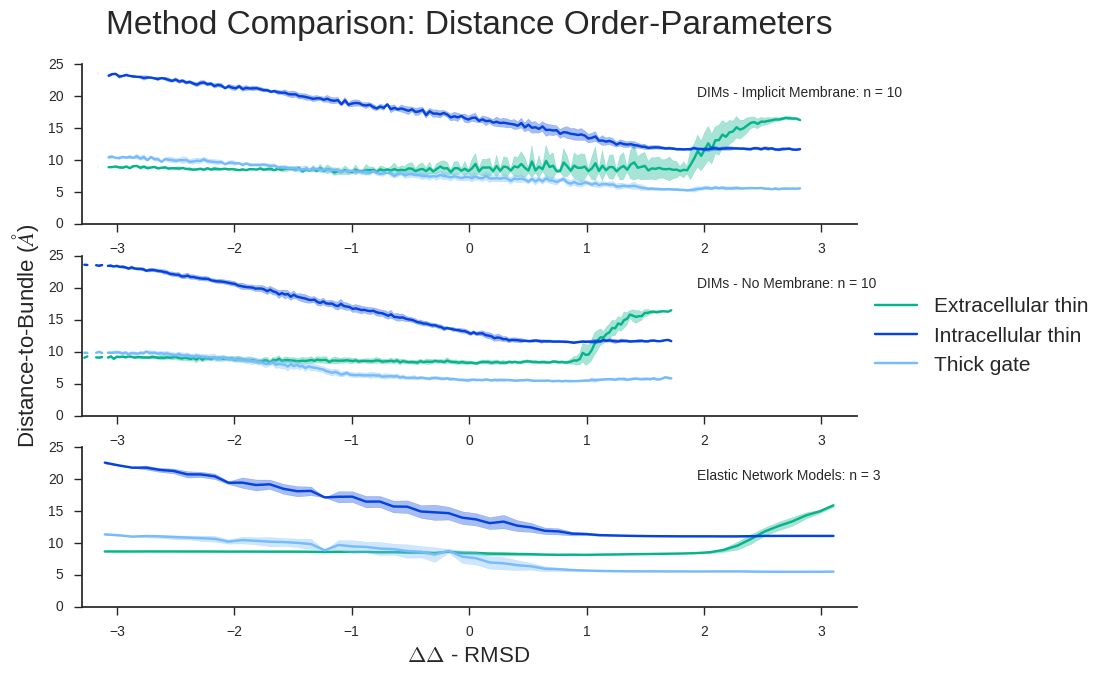

In [109]:
colors = ["green blue", "blue", "sky blue"]
gatenames = ["Extracellular thin", "Intracellular thin", "Thick gate"]

    
sns.set_style("ticks")
fig = plt.figure(figsize = (10, 7))
ax1 = plt.subplot(311)  
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

sns.despine(fig, right=True, top=True)

# def get_axis_limits(ax, scale=.8):
#     return ax.get_xlim()[1]*scale - .7, ax.get_ylim()[1]*scale

#TC_DIMs

ax1.fill_between(TC_zeta, TC_g_mean_1 - TC_g_std_1, TC_g_mean_1 + TC_g_std_1, color=sns.xkcd_rgb[colors[0]], alpha=0.35)
ax1.fill_between(TC_zeta, TC_g_mean_2 - TC_g_std_2, TC_g_mean_2 + TC_g_std_2, color=sns.xkcd_rgb[colors[1]], alpha=0.35)
ax1.fill_between(TC_zeta, TC_g_mean_3 - TC_g_std_3, TC_g_mean_3 + TC_g_std_3, color=sns.xkcd_rgb[colors[2]], alpha=0.35)

ax1.plot(TC_zeta, TC_g_mean_1, c=sns.xkcd_rgb[colors[0]], label = gatenames[0], zorder = 0)
ax1.plot(TC_zeta, TC_g_mean_2, c=sns.xkcd_rgb[colors[1]], label = gatenames[1], zorder = 1)
ax1.plot(TC_zeta, TC_g_mean_3, c=sns.xkcd_rgb[colors[2]], label = gatenames[2], zorder = 2)

#OB_DIMs

ax2.fill_between(OB_zeta, OB_g_mean_1 - OB_g_std_1, OB_g_mean_1 + OB_g_std_1, color=sns.xkcd_rgb[colors[0]], alpha=0.35)
ax2.fill_between(OB_zeta, OB_g_mean_2 - OB_g_std_2, OB_g_mean_2 + OB_g_std_2, color=sns.xkcd_rgb[colors[1]], alpha=0.35)
ax2.fill_between(OB_zeta, OB_g_mean_3 - OB_g_std_3, OB_g_mean_3 + OB_g_std_3, color=sns.xkcd_rgb[colors[2]], alpha=0.35)

ax2.plot(OB_zeta, OB_g_mean_1, c=sns.xkcd_rgb[colors[0]], label = gatenames[0], zorder = 0)
ax2.plot(OB_zeta, OB_g_mean_2, c=sns.xkcd_rgb[colors[1]], label = gatenames[1], zorder = 1)
ax2.plot(OB_zeta, OB_g_mean_3, c=sns.xkcd_rgb[colors[2]], label = gatenames[2], zorder = 2)

#ENM

ax3.fill_between(ENM_zeta, ENM_g_mean_1 - ENM_g_std_1, ENM_g_mean_1 + ENM_g_std_1, color=sns.xkcd_rgb[colors[0]], alpha=0.35)
ax3.fill_between(ENM_zeta, ENM_g_mean_2 - ENM_g_std_2, ENM_g_mean_2 + ENM_g_std_2, color=sns.xkcd_rgb[colors[1]], alpha=0.35)
ax3.fill_between(ENM_zeta, ENM_g_mean_3 - ENM_g_std_3, ENM_g_mean_3 + ENM_g_std_3, color=sns.xkcd_rgb[colors[2]], alpha=0.35)

ax3.plot(ENM_zeta, ENM_g_mean_1, c=sns.xkcd_rgb[colors[0]], label = gatenames[0], zorder = 0)
ax3.plot(ENM_zeta, ENM_g_mean_2, c=sns.xkcd_rgb[colors[1]], label = gatenames[1], zorder = 1)
ax3.plot(ENM_zeta, ENM_g_mean_3, c=sns.xkcd_rgb[colors[2]], label = gatenames[2], zorder = 2)

for ax in [ax1, ax2, ax3]:
    ax.axis([-3.3, 3.3, 0, 25])
    
# ax2.axis([-3.3, 2.0, 0, 25])

# for ax in [ax1, ax2]:
#     ax.axes.get_xaxis().set_visible(False)

ax1.grid(False)
ax2.grid(False)
ax3.grid(False)

ax2.legend(loc = 'center left', bbox_to_anchor=(1, 0.5), prop = {'size':15})

ax1.set_title("Method Comparison: Distance Order-Parameters", fontsize = "24", y = 1.15 )
ax2.set_ylabel(r"Distance-to-Bundle ($\AA$)", size = 16)
ax3.set_xlabel(r"$\Delta\Delta$ - RMSD", size = 16)

ax1.annotate('DIMs - Implicit Membrane: n = 10', xy = get_axis_limits(ax1))
ax2.annotate('DIMs - No Membrane: n = 10', xy = get_axis_limits(ax2))
ax3.annotate('Elastic Network Models: n = 3', xy = get_axis_limits(ax3))

plt.savefig("Kill_test_fig.pdf", bbox_inches="tight")

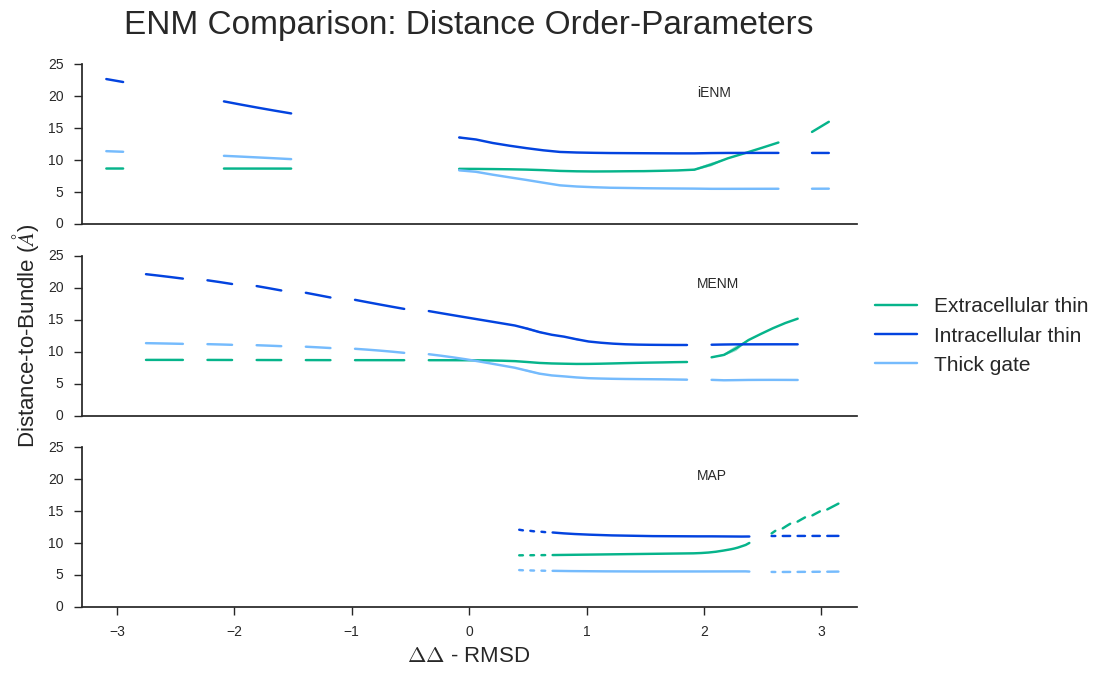

In [52]:
colors = ["green blue", "blue", "sky blue"]
gatenames = ["Extracellular thin", "Intracellular thin", "Thick gate"]

    
sns.set_style("ticks")
fig = plt.figure(figsize = (10, 7))
ax1 = plt.subplot(311)  
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

sns.despine(fig, right=True, top=True)

def get_axis_limits(ax, scale=.8):
    return ax.get_xlim()[1]*scale - .7, ax.get_ylim()[1]*scale

#iENM

ax1.fill_between(iENM_zeta, iENM_g_mean_1 - iENM_g_std_1, iENM_g_mean_1 + iENM_g_std_1, color=sns.xkcd_rgb[colors[0]], alpha=0.35)
ax1.fill_between(iENM_zeta, iENM_g_mean_2 - iENM_g_std_2, iENM_g_mean_2 + iENM_g_std_2, color=sns.xkcd_rgb[colors[1]], alpha=0.35)
ax1.fill_between(iENM_zeta, iENM_g_mean_3 - iENM_g_std_3, iENM_g_mean_3 + iENM_g_std_3, color=sns.xkcd_rgb[colors[2]], alpha=0.35)

ax1.plot(iENM_zeta, iENM_g_mean_1, c=sns.xkcd_rgb[colors[0]], label = gatenames[0], zorder = 0)
ax1.plot(iENM_zeta, iENM_g_mean_2, c=sns.xkcd_rgb[colors[1]], label = gatenames[1], zorder = 1)
ax1.plot(iENM_zeta, iENM_g_mean_3, c=sns.xkcd_rgb[colors[2]], label = gatenames[2], zorder = 2)

#MENM

ax2.fill_between(MENM_zeta, MENM_g_mean_1 - MENM_g_std_1, MENM_g_mean_1 + MENM_g_std_1, color=sns.xkcd_rgb[colors[0]], alpha=0.35)
ax2.fill_between(MENM_zeta, MENM_g_mean_2 - MENM_g_std_2, MENM_g_mean_2 + MENM_g_std_2, color=sns.xkcd_rgb[colors[1]], alpha=0.35)
ax2.fill_between(MENM_zeta, MENM_g_mean_3 - MENM_g_std_3, MENM_g_mean_3 + MENM_g_std_3, color=sns.xkcd_rgb[colors[2]], alpha=0.35)

ax2.plot(MENM_zeta, MENM_g_mean_1, c=sns.xkcd_rgb[colors[0]], label = gatenames[0], zorder = 0)
ax2.plot(MENM_zeta, MENM_g_mean_2, c=sns.xkcd_rgb[colors[1]], label = gatenames[1], zorder = 1)
ax2.plot(MENM_zeta, MENM_g_mean_3, c=sns.xkcd_rgb[colors[2]], label = gatenames[2], zorder = 2)

#MAP

ax3.fill_between(MAP_zeta, MAP_g_mean_1 - MAP_g_std_1, MAP_g_mean_1 + MAP_g_std_1, color=sns.xkcd_rgb[colors[0]], alpha=0.35)
ax3.fill_between(MAP_zeta, MAP_g_mean_2 - MAP_g_std_2, MAP_g_mean_2 + MAP_g_std_2, color=sns.xkcd_rgb[colors[1]], alpha=0.35)
ax3.fill_between(MAP_zeta, MAP_g_mean_3 - MAP_g_std_3, MAP_g_mean_3 + MAP_g_std_3, color=sns.xkcd_rgb[colors[2]], alpha=0.35)

ax3.plot(MAP_zeta, MAP_g_mean_1, c=sns.xkcd_rgb[colors[0]], label = gatenames[0], zorder = 0)
ax3.plot(MAP_zeta, MAP_g_mean_2, c=sns.xkcd_rgb[colors[1]], label = gatenames[1], zorder = 1)
ax3.plot(MAP_zeta, MAP_g_mean_3, c=sns.xkcd_rgb[colors[2]], label = gatenames[2], zorder = 2)

for ax in [ax1, ax2, ax3]:
    ax.axis([-3.3, 3.3, 0, 25])

for ax in [ax1, ax2]:
    ax.axes.get_xaxis().set_visible(False)

ax1.grid(False)
ax2.grid(False)
ax3.grid(False)

ax2.legend(loc = 'center left', bbox_to_anchor=(1, 0.5), prop = {'size':15})

ax1.set_title("ENM Comparison: Distance Order-Parameters", fontsize = "24", y = 1.15 )
ax2.set_ylabel(r"Distance-to-Bundle ($\AA$)", size = 16)
ax3.set_xlabel(r"$\Delta\Delta$ - RMSD", size = 16)

ax1.annotate('iENM', xy = get_axis_limits(ax1))
ax2.annotate('MENM', xy = get_axis_limits(ax2))
ax3.annotate('MAP', xy = get_axis_limits(ax3))

plt.savefig("Kill_ENM_test_fig.pdf", bbox_inches="tight")

## Outward to Occluded to Inward

In [ ]:

OB_trjs = [glob.glob("../data/dims/oliver/implicit_no_memb/out2occ2in/" 
                         + i + str(j).zfill(3) + "*.dcd") 
               for i in ["gates/", "TM3_TM8_fixed/"] for j in xrange(20, 30)]

TC_trjs = [glob.glob("../data/dims/TC_DIMS_raw/traj_" + str(i).zfill(3)) for i in xrange(1, 11)]

ENMs = ["ANM-Pathway/", "GOdMD/", "iENM/", "MAP/", "MDdMD/", "PATH-ENM/Saddle", "PATH-ENM/Steep_Descent"]

legs = ["in2occ", "out2occ"]

ENM_trjs = [glob.glob("../data/public_servers/" + method + leg + "true*" + str(i) + ".pdb") 
                for i in [1,2,3] for leg in legs for method in ENMs]